In [1]:
from model import LAMOI, Regression
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import random
from sklearn import metrics
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
import math
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.spatial.distance import pdist, squareform
from sklearn.feature_selection import VarianceThreshold

import wandb
from tqdm import tqdm
import warnings
import os

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_auc(P, GT, mask_eval):
    drug_response_gt, drug_response_p = [], []
    
    for i in range(len(np.array(P))):
        temp_gt, temp_p = [], []
        for j in range(len(np.array(mask_eval)[i])):
            if np.array(mask_eval)[i][j] == 1:
                temp_gt.append(np.array(GT)[i][j])
                temp_p.append(np.array(P)[i][j])
        drug_response_gt.append(temp_gt)
        drug_response_p.append(temp_p)
    
    auc_list = []
    for i in range(len(drug_response_gt)):
        try:
            AUC = metrics.roc_auc_score(drug_response_gt[i], drug_response_p[i])
            auc_list.append(AUC)
        except:
            continue
    
    return np.array(auc_list)

def metric(TP, TN, FP, FN):
    try: acc = (TP + TN) / (TP + TN + FP + FN)
    except: acc = 0
    try: precision = TP  / (TP + FP)
    except: precision = 0
    try: recall = TP  / (TP + FN)
    except: recall = 0
    try: f1 = (2 * precision * recall) / (recall + precision)
    except: f1 = 0
    return acc, precision, recall, f1

def evaluate(pred, gt, mask):
    TP = [0 for i in range(len(gt))]
    TN, FP, FN = TP.copy(), TP.copy(), TP.copy()
    acc = [None for i in range(len(TP))]
    precision, recall, f1 = acc.copy(), acc.copy(), acc.copy()
    for i in range(len(mask)):
        for j in range(len(mask[i])):
            if mask[i][j] != 0:
                if gt[i][j] == pred[i][j]:
                    if gt[i][j] == 1: TP[i] += 1
                    else : TN[i] += 1
                else:
                    if gt[i][j] == 1: FN[i] += 1
                    else : FP[i] += 1
        acc[i], precision[i], recall[i], f1[i] = metric(TP[i], TN[i], FP[i], FN[i])
    return np.array(acc), np.array(precision), np.array(recall), np.array(f1)

# Normalize using min-max or standardize
def normalize(data, idx_train, N_type):
    scaler = {'s' : None, 'mm' : None}
    
    if N_type == 0:
        scaler['s'] = StandardScaler().fit(data.iloc[idx_train, :])
        data_df = pd.DataFrame(scaler['s'].transform(data))
    elif N_type == 1:
        scaler['mm'] = MinMaxScaler().fit(data.iloc[idx_train, :])
        data_df = pd.DataFrame(scaler['mm'].transform(data))
    else: return data, scaler
        
    data_df.columns = data.columns
    data_df.index = data.index
    return data_df, scaler

def inverse_normalize(data, scaler, N_type):
    if N_type != 0 and N_type != 1:
        return data
    s = scaler['s'] if N_type == 0 else scaler['mm']
    original_data = s.inverse_transform(data)
    return original_data

def get_fewer_drugs(data, threshold):
    data_copy = data.copy()
    for drug in data.columns:
        if data[drug].isna().sum() > len(data[drug]) * threshold:
            data_copy = data_copy.drop([drug], axis = 1)
    return data_copy

def drug_preprocessing(x, drug, method):
    drug_pre = drug.copy()
    if method == 'mean':
        mean = np.array(drug.describe().T['mean'])
        for i in range(len(drug.columns)):
            for j in range(len(drug.iloc[:, i])):
                if np.isnan(drug.iloc[j, i]):
                    drug.iloc[j, i] = mean[i]
    elif method == 'sim':
        x = pd.DataFrame(np.concatenate((x[0], x[1], x[2]), axis=1))
        sim = squareform(pdist(x))
        for i in range(len(drug.columns)):
            for j in range(len(drug.iloc[:, i])):
                if np.isnan(drug.iloc[j, i]):
                    search = np.array(pd.DataFrame(sim[j], columns = ['sim']).sort_values(by = 'sim').index)
                    for k in search:
                        if not np.isnan(drug.iloc[k, i]) and k != j:
                            drug.iloc[j, i] = drug.iloc[k, i]
    return drug_pre, drug

def Variance_FS(data, thres):
    variance = VarianceThreshold(threshold = thres)
    variance.fit(data)
    columns = [column for column in data.columns if column not in data.columns[variance.get_support()]]
    return data.drop(labels = columns, axis = 1)  

def data_preprocessing(X_dir, Y_dir, paras):
    #read csv
    data_X = [pd.read_csv(file_name).set_index('Unnamed: 0') for file_name in X_dir]
    data_Y = pd.read_csv(Y_dir).set_index('Unnamed: 0')
    
#     split train & test data
    index = [i for i in range(len(data_Y))]
    idx_train, idx_test, _, _ = train_test_split(index, data_Y, test_size = 0.2, random_state = paras['seed'])
    
    drug_ori, drug_pro = drug_preprocessing(data_X, data_Y, paras['method'])

    X = {'train' : [], 'test' : []}
    
    for i in range(len(data_X)):
        std_data, _ = normalize(data_X[i], idx_train, paras['N_type'])
        X['train'].append(std_data.iloc[idx_train, :])
        X['test'].append(std_data.iloc[idx_test, :])
    
    
    std_data, scaler = normalize(drug_ori, idx_train, paras['N_type'])
    Y = {'train' :  {'pro' : drug_pro.iloc[idx_train, :], 'ori' : drug_ori.iloc[idx_train, :], 'std' : std_data.iloc[idx_train, :]}, 
         'test' : {'pro' : drug_pro.iloc[idx_test, :], 'ori' : drug_ori.iloc[idx_test, :]}, 'std' : std_data.iloc[idx_test, :]} 
    
    return X, Y, Y['train']['ori'].describe().T['50%'], Y['train']['ori'].describe().T['std'], scaler

In [3]:
dir_path = './data/preprocessing/'
X_dir = [dir_path + 'methylation.csv', dir_path + 'expression.csv', dir_path + 'cnv.csv', dir_path + 'mutation.csv']
Y_dir = dir_path + 'IC50(log).csv'

paras = {
    'seed' : 42, 
    'device' : 'cuda:0' if torch.cuda.is_available() == True else 'cpu', 
    'N_type' : 1, 
    'thres' : 0.3, 
    'method' : None
}

X, Y, median, std, scaler = data_preprocessing(X_dir, Y_dir, paras)

In [4]:
paras['median'] = median
paras['std'] = std
paras['scaler'] = scaler
paras['lr'] = {'model' : 1e-6, 'reg' : 1e-5}
paras['epochs'] = 200
paras['dropout'] = 0.2
paras['batch_size'] = 2
paras['Weight'] = 1.0
paras['temperature'] = 1.0
paras['h_layer'] = 2
paras['max_hdim'] = 4096
paras['k_fold'] = 3
paras['z_dim'] = 1024
paras['k'] = 40
paras['channel'] = 2
paras['drug_std'] = False
paras['attention'] = True
paras['cell_line'] = 25
paras['drug_index'] = 26

Methylation = True
Expression = True
CNV = True
Mutation = True
dataset = []
data_name = ['Me', 'Ex', 'CNV', 'Mu']
if Methylation:
    dataset.append(0)
if Expression:
    dataset.append(1)
if CNV:
    dataset.append(2)
if Mutation:
    dataset.append(3)

paras['name'] = '('
for i in range(len(dataset)):
    if i == len(dataset) - 1:
        paras['name'] += data_name[dataset[i]] + ')'
    else:
        paras['name'] += data_name[dataset[i]] + ', '

paras['name']

x_train = [X['train'][i] for i in dataset]
x_test = [X['test'][i] for i in dataset]

In [5]:
def get_feature_importance_for_all(data, drug_index):
    features_importance = [data[0][j][drug_index] for j in range(len(data[0]))]
    for i in range(1, 4):
        features_importance += [data[i][j][drug_index] for j in range(len(data[i]))] 
    xmax = np.array(features_importance).max()
    xmin = np.array(features_importance).min()
#     temp = [2 * (features_importance[j] - xmin) / (xmax - xmin) - 1 for j in range(len(features_importance)) if (xmax - xmin) !=0]
    temp = [(features_importance[j] - xmin) / (xmax - xmin) for j in range(len(features_importance)) if (xmax - xmin) !=0]
    if len(temp) == 0:
        temp = [0 for j in range(len(features_importance))]
    omics_features_importance = temp
        
    return omics_features_importance

In [6]:
def get_gene_importance(data_x, data_y, index, dataset, base, model, reg, paras):
    loss, acc, precision, recall, f1, auc = {}, {}, {}, {}, {}, {}
    
    if type(data_x) == 'dict':
        for i in range(len(data_x[index].columns)):
            x = [data_x[j].copy() for j in dataset]
            x[index].iloc[:, i] = 0
            loss_temp, acc_temp, precision_temp, recall_temp, f1_temp, auc_temp, _, _, _ = test(x, data_y['ori'], data_y['pro'], model, reg, paras)
            loss[i] = loss_temp - base['loss']
            if 'acc' in base:
                acc[i] = acc_temp - base['acc']
                precision[i] = precision_temp - base['precision']
                recall[i] = recall_temp - base['recall']
                f1[i] = f1_temp - base['f1']
                auc[i] = auc_temp - base['auc']
        return {'loss' : loss, 'acc' : acc, 'precision' : precision, 'recall' : recall, 'f1' : f1, 'auc' : auc}
    else :
        for i in range(np.shape(data_x[index])[1]):
            x = [data_x[j].copy() for j in dataset]
            x[index][:, i] = 0
            loss_temp, acc_temp, precision_temp, recall_temp, f1_temp, auc_temp, _, _, _ = test(x, data_y['ori'], data_y['pro'], model, reg, paras)
            loss[i] = loss_temp - base['loss']
            if 'acc' in base:
                acc[i] = acc_temp - base['acc']
                precision[i] = precision_temp - base['precision']
                recall[i] = recall_temp - base['recall']
                f1[i] = f1_temp - base['f1']
                auc[i] = auc_temp - base['auc']
        return {'loss' : loss}

In [8]:
def test(x, y_ori, y_pro, model, reg, paras):
    if type(x[0]) == type(y_ori):
        tensor_test_x = [torch.FloatTensor(x[i].to_numpy()).to(paras['device']) for i in range(len(x))]
    else:
        tensor_test_x = [torch.FloatTensor(x[i]).to(paras['device']) for i in range(len(x))]
    tensor_test_y_ori = torch.FloatTensor(y_ori.to_numpy())
    tensor_test_y_pro = torch.FloatTensor(y_pro.to_numpy())
    
    loss_MSE = nn.MSELoss()
    with torch.no_grad():
        model.to(paras['device'])
        model.eval()
        reg.to(paras['device'])
        reg.eval()

        mask_eval, label_reg = [], []
        if len(tensor_test_y_ori.size()) == 1:
            tensor_test_y_ori = torch.unsqueeze(tensor_test_y_ori, 0)
            tensor_test_y_pro = torch.unsqueeze(tensor_test_y_pro, 0)
        for i in range(len(tensor_test_y_ori)):
            mask_eval.append([0 if np.isnan(tensor_test_y_ori[i][j]) else 1 for j in range(len(tensor_test_y_ori[i]))])
            label_reg.append([0 if np.isnan(tensor_test_y_ori[i][j]) else tensor_test_y_ori[i][j] for j in range(len(tensor_test_y_ori[i]))])
        

        label_reg = torch.FloatTensor(label_reg)

        encode, concat_data = model(tensor_test_x)

        Pred_reg = reg(concat_data)

        P_reg = Pred_reg.detach().cpu().numpy().copy()
        pre_y = label_reg.detach().cpu().numpy().copy()
        pre_p = P_reg
        if paras['drug_std']:
            P_reg = inverse_normalize(P_reg, paras['scaler'], paras['N_type'])
        P_reg = P_reg * mask_eval
        
        loss = []
        for i in range(len(np.array(P_reg).T)):
            loss.append(loss_MSE(torch.FloatTensor(np.array(P_reg).T[i]), label_reg.T[i]))
#         loss = loss_MSE(torch.FloatTensor(P_reg), label_reg)
        if tensor_test_y_ori.size()[0] == 1:
            return np.array(loss), None, None, None, None, None, pre_p, pre_y, mask_eval
        else:
            P = np.array([[1 if P_reg[i][j] < paras['median'][j] else 0 for j in range(len(P_reg[i]))] for i in range(len(P_reg))]) * mask_eval
            GT = [[0 if np.isnan(tensor_test_y_ori[i][j]) else 1 if tensor_test_y_pro[i][j] < paras['median'][j] else 0 for j in range(len(tensor_test_y_pro[i]))] for i in range(len(tensor_test_y_pro))]
            acc, precision, recall, f1 = evaluate(P.T, np.array(GT).T, np.array(mask_eval).T)
            auc = get_auc(P.T, np.array(GT).T, np.array(mask_eval).T)
        
    return np.array(loss), acc, precision, recall, f1, auc, pre_p, pre_y, mask_eval

In [10]:
def get_gene_weight(x, y, paras):
    if paras['drug_std']:
        dir_name = './model/{}/{}/drug_std/{}fold/fold:{}'.format(paras['name'], paras['method'], paras['k_fold'], 0)
    else:
        dir_name = './model/{}/{}/{}fold/fold:{}'.format(paras['name'], paras['method'], paras['k_fold'], 0)

    model = torch.load(dir_name + '/LAMOI/hlayer({})_thres({})_epoch({})_bs({})_lr({})_dropout({})_tem({})_weight({})_zdim({})_k({})_ch({})_attn({}).pth'.format(
                        paras['h_layer'], 
                        paras['thres'], 
                        paras['epochs'], 
                        paras['batch_size'], 
                        paras['lr'], 
                        paras['dropout'], 
                        paras['temperature'],
                        paras['Weight'],  
                        paras['z_dim'], 
                        paras['k'],
                        paras['channel'],
                        paras['attention']
                    ))
    reg = torch.load(dir_name + '/reg/hlayer({})_thres({})_epoch({})_bs({})_lr({})_dropout({})_tem({})_weight({})_zdim({})_k({})_ch({})_attn({}).pth'.format(
                        paras['h_layer'], 
                        paras['thres'], 
                        paras['epochs'], 
                        paras['batch_size'], 
                        paras['lr'], 
                        paras['dropout'], 
                        paras['temperature'],
                        paras['Weight'],  
                        paras['z_dim'], 
                        paras['k'],
                        paras['channel'],
                        paras['attention']
                    ))
    
    x_temp = x.copy()
    for i in range(len(x_temp)):
        x_temp[i] = np.array(x_temp[i].iloc[paras['cell_line'], :]).reshape((1, -1))
    y_temp = {'ori' : y['ori'].iloc[paras['cell_line'],:], 'pro' : y['pro'].iloc[paras['cell_line'],:]}
    cell_line_loss_base, _, _, _, _, _, cell_line_P, cell_line_GT, cell_line_mask_eval = test(x_temp, y_temp['ori'].copy(), y_temp['pro'].copy(), model, reg, paras)
    loss_base, acc_base, precision_base, recall_base, f1_base, auc_base, P, GT, mask_eval = test(x, y['ori'].copy(), y['pro'].copy(), model, reg, paras)
    cell_line_base = {'loss' : loss_base}
    
    cell_line_Me_feature_importance = get_gene_importance(x_temp, y_temp, 0, paras['dataset'], cell_line_base, model, reg, paras)
    cell_line_Ex_feature_importance = get_gene_importance(x_temp, y_temp, 1, paras['dataset'], cell_line_base, model, reg, paras)
    cell_line_CNV_feature_importance = get_gene_importance(x_temp, y_temp, 2, paras['dataset'], cell_line_base, model, reg, paras)
    cell_line_Mu_feature_importance = get_gene_importance(x_temp, y_temp, 3, paras['dataset'], cell_line_base, model, reg, paras)
    
    cell_data = [cell_line_Me_feature_importance['loss'], cell_line_Ex_feature_importance['loss'], cell_line_CNV_feature_importance['loss'], cell_line_Mu_feature_importance['loss']]
    
    drug_related = pd.DataFrame(get_feature_importance_for_all(cell_data, paras['drug_index']), index = list(x[0].columns)+list(x[1].columns)+list(x[2].columns)+list(x[3].columns))
    drug_related.index = [drug_related.index[paras['drug_index']].split('_')[0] for i in range(len(drug_related.index))]
    
    if not os.path.exists('result/'):
        os.makedirs('result/')
        
    if not os.path.exists('result/reaction/cell({})'.format(x[0].index[paras['cell_line']])):
        os.makedirs('result/reaction/cell({})'.format(x[0].index[paras['cell_line']]))
#     drug_related.sort_values(by = [0], ascending=False).to_csv('result/reaction/cell({})/drug({})_all.csv'.format(x[0].index[paras['cell_line']], y['pro'].columns[paras['drug_index']]))
    
get_gene_weight(x_test, Y['test'], paras)

RuntimeError: CUDA out of memory. Tried to allocate 304.00 MiB (GPU 0; 10.92 GiB total capacity; 1.41 GiB already allocated; 302.50 MiB free; 1.42 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [5]:
k = 0
if paras['drug_std']:
    dir_name = './model/{}/{}/drug_std/{}fold/fold:{}'.format(paras['name'], paras['method'], paras['k_fold'], k)
else:
    dir_name = './model/{}/{}/{}fold/fold:{}'.format(paras['name'], paras['method'], paras['k_fold'], k)

model = torch.load(dir_name + '/LAMOI/hlayer({})_thres({})_epoch({})_bs({})_lr({})_dropout({})_tem({})_weight({})_zdim({})_k({})_ch({})_attn({}).pth'.format(
                    paras['h_layer'], 
                    paras['thres'], 
                    paras['epochs'], 
                    paras['batch_size'], 
                    paras['lr'], 
                    paras['dropout'], 
                    paras['temperature'],
                    paras['Weight'],  
                    paras['z_dim'], 
                    paras['k'],
                    paras['channel'],
                    paras['attention']
                ))
reg = torch.load(dir_name + '/reg/hlayer({})_thres({})_epoch({})_bs({})_lr({})_dropout({})_tem({})_weight({})_zdim({})_k({})_ch({})_attn({}).pth'.format(
                    paras['h_layer'], 
                    paras['thres'], 
                    paras['epochs'], 
                    paras['batch_size'], 
                    paras['lr'], 
                    paras['dropout'], 
                    paras['temperature'],
                    paras['Weight'],  
                    paras['z_dim'], 
                    paras['k'],
                    paras['channel'],
                    paras['attention']
                ))

def test(x, y_ori, y_pro):
    if type(x[0]) == type(y_ori):
        tensor_test_x = [torch.FloatTensor(x[i].to_numpy()).to(paras['device']) for i in range(len(x))]
    else:
        tensor_test_x = [torch.FloatTensor(x[i]).to(paras['device']) for i in range(len(x))]
    tensor_test_y_ori = torch.FloatTensor(y_ori.to_numpy())
    tensor_test_y_pro = torch.FloatTensor(y_pro.to_numpy())
    
    loss_MSE = nn.MSELoss()
    with torch.no_grad():
        model.to(paras['device'])
        model.eval()
        reg.to(paras['device'])
        reg.eval()

        mask_eval, label_reg = [], []
        if len(tensor_test_y_ori.size()) == 1:
            tensor_test_y_ori = torch.unsqueeze(tensor_test_y_ori, 0)
            tensor_test_y_pro = torch.unsqueeze(tensor_test_y_pro, 0)
        for i in range(len(tensor_test_y_ori)):
            mask_eval.append([0 if np.isnan(tensor_test_y_ori[i][j]) else 1 for j in range(len(tensor_test_y_ori[i]))])
            label_reg.append([0 if np.isnan(tensor_test_y_ori[i][j]) else tensor_test_y_ori[i][j] for j in range(len(tensor_test_y_ori[i]))])
        

        label_reg = torch.FloatTensor(label_reg)

        encode, concat_data = model(tensor_test_x)

        Pred_reg = reg(concat_data)

        P_reg = Pred_reg.detach().cpu().numpy().copy()
        pre_y = label_reg.detach().cpu().numpy().copy()
        pre_p = P_reg
        if paras['drug_std']:
            P_reg = inverse_normalize(P_reg, paras['scaler'], paras['N_type'])
        P_reg = P_reg * mask_eval
        
        loss = []
        for i in range(len(np.array(P_reg).T)):
            loss.append(loss_MSE(torch.FloatTensor(np.array(P_reg).T[i]), label_reg.T[i]))
#         loss = loss_MSE(torch.FloatTensor(P_reg), label_reg)
        if tensor_test_y_ori.size()[0] == 1:
            return np.array(loss), None, None, None, None, None, pre_p, pre_y, mask_eval
        else:
            P = np.array([[1 if P_reg[i][j] < paras['median'][j] else 0 for j in range(len(P_reg[i]))] for i in range(len(P_reg))]) * mask_eval
            GT = [[0 if np.isnan(tensor_test_y_ori[i][j]) else 1 if tensor_test_y_pro[i][j] < paras['median'][j] else 0 for j in range(len(tensor_test_y_pro[i]))] for i in range(len(tensor_test_y_pro))]
            acc, precision, recall, f1 = evaluate(P.T, np.array(GT).T, np.array(mask_eval).T)
            auc = get_auc(P.T, np.array(GT).T, np.array(mask_eval).T)
        
    return np.array(loss), acc, precision, recall, f1, auc, pre_p, pre_y, mask_eval

In [6]:
def get_feature_importance(data_x, data_y, index, dataset, base):
    loss, acc, precision, recall, f1, auc = {}, {}, {}, {}, {}, {}
    
    if type(data_x) == 'dict':
        for i in range(len(data_x[index].columns)):
            x = [data_x[j].copy() for j in dataset]
            x[index].iloc[:, i] = 0
            loss_temp, acc_temp, precision_temp, recall_temp, f1_temp, auc_temp, _, _, _ = test(x, data_y['ori'], data_y['pro'])
            loss[i] = loss_temp - base['loss']
            if 'acc' in base:
                acc[i] = acc_temp - base['acc']
                precision[i] = precision_temp - base['precision']
                recall[i] = recall_temp - base['recall']
                f1[i] = f1_temp - base['f1']
                auc[i] = auc_temp - base['auc']
        return {'loss' : loss, 'acc' : acc, 'precision' : precision, 'recall' : recall, 'f1' : f1, 'auc' : auc}
    else :
        for i in range(np.shape(data_x[index])[1]):
            x = [data_x[j].copy() for j in dataset]
            x[index][:, i] = 0
            loss_temp, acc_temp, precision_temp, recall_temp, f1_temp, auc_temp, _, _, _ = test(x, data_y['ori'], data_y['pro'])
            loss[i] = loss_temp - base['loss']
            if 'acc' in base:
                acc[i] = acc_temp - base['acc']
                precision[i] = precision_temp - base['precision']
                recall[i] = recall_temp - base['recall']
                f1[i] = f1_temp - base['f1']
                auc[i] = auc_temp - base['auc']
        return {'loss' : loss}

In [7]:
def get_omics_importance(data_x, data_y, index, dataset, base):
    loss, acc, precision, recall, f1, auc = {}, {}, {}, {}, {}, {}
    
    x = [data_x[i].copy() for i in dataset]
    x[index].iloc[:, :] = 0
    loss_temp, acc_temp, precision_temp, recall_temp, f1_temp, auc_temp, _, _, _ = test(x, data_y['ori'], data_y['pro'])
    loss = loss_temp - base['loss']
    acc = acc_temp - base['acc']
    precision = precision_temp - base['precision']
    recall = recall_temp - base['recall']
    f1 = f1_temp - base['f1']
    auc = auc_temp - base['auc']
    return {'loss' : loss, 'acc' : acc, 'precision' : precision, 'recall' : recall, 'f1' : f1, 'auc' : auc}

In [8]:
x_test = [X['test'][i].copy() for i in dataset]
loss_base, acc_base, precision_base, recall_base, f1_base, auc_base, P, GT, mask_eval = test(x_test, Y['test']['ori'].copy(), Y['test']['pro'].copy())

In [9]:
base = {'loss' : loss_base, 'acc' : acc_base,  'precision' : precision_base, 'recall' : recall_base, 'f1' : f1_base, 'auc' : auc_base}

In [10]:
Me_importance = get_omics_importance(x_test, Y['test'].copy(), 0, dataset, base)

In [11]:
Ex_importance = get_omics_importance(x_test, Y['test'].copy(), 1, dataset, base)

In [12]:
CNV_importance = get_omics_importance(x_test, Y['test'].copy(), 2, dataset, base)

In [13]:
Mu_importance = get_omics_importance(x_test, Y['test'].copy(), 3, dataset, base)

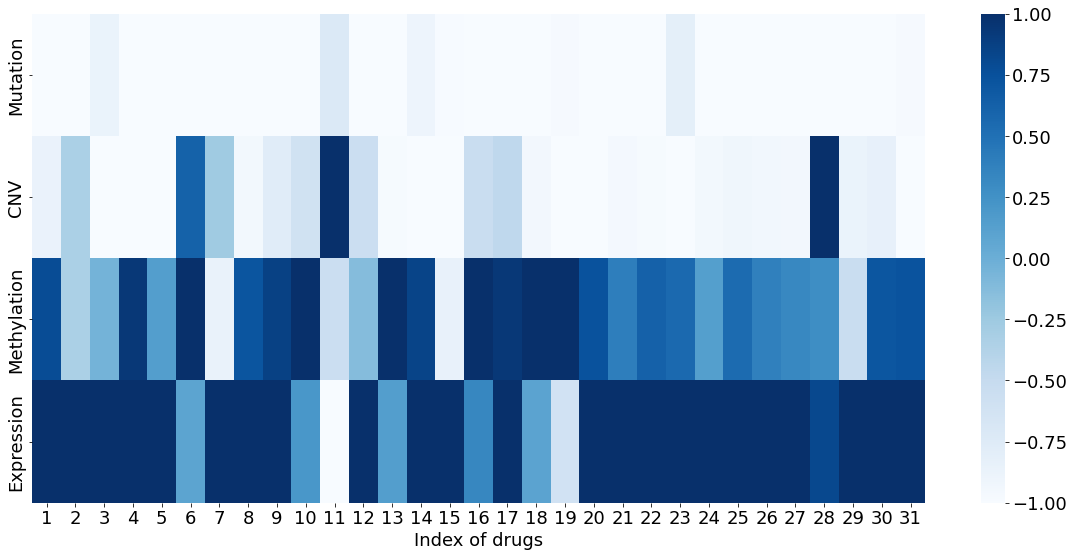

In [14]:
from sklearn.preprocessing import MaxAbsScaler
import seaborn as sns
import matplotlib.pyplot as plt

def get_omics_heatmap(data, index):
    temp_list = []
    for i in range(len(data[0])):
        temp = np.array([data[j][i] for j in range(len(data))])
        xmax = temp.max()
        xmin = temp.min()
        temp = [2 * (temp[j] - xmin) / (xmax - xmin) - 1 for j in range(len(temp))]
#         temp = [temp[j] / xmax if temp[j] > 0 else -temp[j] / xmin for j in range(len(temp))]
        temp_list.append(temp)
    if index == None:
        temp_pd = pd.DataFrame(np.array(temp_list).T, columns = [i for i in range(len(temp_list))])
        plt.yticks([])
    else:
        temp_pd = pd.DataFrame(np.array(temp_list).T, index = index, columns = [i + 1 for i in range(len(temp_list))])
    
    plt.figure(figsize = (20, 9))
    plt.rc('font', size = 18)
    sns.heatmap(temp_pd, cmap = 'Blues', center = 0)
    plt.xlabel('Index of drugs', size = 18)
#     plt.savefig('result/datasets_importance.png', transparent = True)

metric = 'loss'    
get_omics_heatmap([Mu_importance[metric], CNV_importance[metric], Me_importance[metric], Ex_importance[metric]], ['Mutation', 'CNV', 'Methylation', 'Expression'])

In [16]:
mask_p = P * mask_eval
mask_gt = GT * mask_eval
loss_cell = []
temp = 0
for i in range(len(mask_p)):
    temp_loss = []
    for j in range(len(mask_p[i])):
        temp_loss.append((mask_p[i][j] - mask_gt[i][j]) ** 2)
    print('{} : {}'.format(i, len(temp_loss) - np.array([1 for i in range(len(temp_loss)) if (temp_loss[i] == 0)]).sum()))
    print(np.array(temp_loss).mean())
    loss_cell.append(np.array(temp_loss))

0 : 26
2.155000508925344
1 : 22
1.6256942556994811
2 : 2
0.11833728856381613
3 : 26
1.3523602852884555
4 : 29
0.726737905759253
5 : 18
0.4174006274321152
6 : 26
2.4994366446160496
7 : 21
0.5700329334183224
8 : 29
1.35455142364639
9 : 24
1.9556526866615898
10 : 24
1.4093290833175234
11 : 27
1.4537595422924825
12 : 29
1.0077695144992826
13 : 26
1.919632682297326
14 : 24
1.2490299844982173
15 : 29
2.0285188400811203
16 : 8
0.40036774197991265
17 : 26
0.6454883055982483
18 : 25
1.084349529791331
19 : 31.0
1.5733408735013366
20 : 26
1.4041852197909435
21 : 18
0.5091853472377741
22 : 28
1.3561232459108565
23 : 29
1.7782524027912523
24 : 24
0.9809758767185094
25 : 31.0
1.4008434369826366
26 : 23
0.6686287739467028
27 : 31.0
1.1579316389863497
28 : 4
0.2564853147944357
29 : 22
0.603091453809097
30 : 29
1.3598058785963163
31 : 31.0
1.571280596545889
32 : 20
1.3441930832496907
33 : 28
1.0410739712967545
34 : 25
0.9744562321592344
35 : 24
2.199493766311221
36 : 30
1.2397180894102307
37 : 26
1.655

In [17]:
Y['test']['ori'].columns

Index(['vorinostat (GDSC1:1012)', 'TW-37 (GDSC1:1149)',
       'LL-Z1640-2 (GDSC1:1242)', 'Piplartine (GDSC1:1243)',
       'doxorubicin (GDSC1:133)', 'mitomycin-C (GDSC1:136)',
       'KIN001-204 (GDSC1:157)', 'Dimethyloxalylglcine (GDSC1:165)',
       'PDK1 inhibitor AR-12 (GDSC1:167)', 'Anchusin (GDSC1:170)',
       'obatoclax (GDSC1:182)', 'dacinostat (GDSC1:200)',
       'JW-7-24-1 (GDSC1:256)', 'ACY-1215 (GDSC1:264)', 'AR-42 (GDSC1:272)',
       'CUDC-101 (GDSC1:273)', 'belinostat (GDSC1:274)',
       'CAY10603 (GDSC1:276)', 'foretinib (GDSC1:308)',
       'tenovin-6 (GDSC1:342)', 'CI-1033 (GDSC1:362)',
       'PF-00299804 (GDSC1:363)', 'GSK1059615 (GDSC1:374)',
       'AST-1306 (GDSC1:381)', 'CPI-613 (GDSC1:415)',
       'Trichostatin A (GDSC1:437)', 'panobinostat (GDSC1:438)',
       'IMD-0354 (GDSC1:442)', 'CD532 (GDSC1:449)', 'LDN-193189 (GDSC1:478)',
       'Fingolimod hydrochloride; Gilenya; TDI-132; Imusera; Gilenia (GDSC1:546)'],
      dtype='object')

In [18]:
have = [0, 4, 5, 16, 18, 20, 22, 26, 30]
inse, inse_num = [], []
cell_index = pd.DataFrame(np.array(loss_cell).mean(1), columns = ['loss']).sort_values(by = ['loss'], ascending=True).index
for cell_line in range(len(cell_index)):
    effect = []
    for i in range(len(Y['test']['ori'].iloc[cell_index[cell_line]])):
        if median[i] > P[cell_index[cell_line]][i] and median[i] > Y['test']['ori'].iloc[cell_index[cell_line]][i]:
            effect.append(i)
    inse_num.append(len(list(set(effect).intersection(have))))
    inse.append(list(set(effect).intersection(have)))

In [19]:
[i for i in range(len(inse_num)) if inse_num[i] >= 3]

[6,
 17,
 19,
 21,
 24,
 26,
 34,
 38,
 43,
 56,
 58,
 60,
 62,
 65,
 67,
 72,
 77,
 79,
 80,
 81,
 82,
 85,
 86,
 87,
 91,
 93,
 94,
 97,
 101,
 106,
 107]

In [20]:
rank = 81
cell_line = cell_index[rank]
Y['test']['ori'].columns[np.array(inse[rank])]

Index(['vorinostat (GDSC1:1012)', 'belinostat (GDSC1:274)',
       'panobinostat (GDSC1:438)', 'CI-1033 (GDSC1:362)'],
      dtype='object')

In [21]:
cell_line

25

In [22]:
X['test'][0].index[cell_line]

'ACH-000004'

In [23]:
inse[rank]

[0, 16, 26, 20]

In [24]:
pd.DataFrame(P[cell_line][inse[rank]], index = Y['test']['ori'].iloc[cell_line][inse[rank]].index, columns = ['IC50']).sort_values(by = ['IC50'], ascending=True)

,IC50
panobinostat (GDSC1:438),-4.894653
belinostat (GDSC1:274),-1.254920
vorinostat (GDSC1:1012),0.346427
CI-1033 (GDSC1:362),2.151698


In [25]:
pd.DataFrame(Y['test']['ori'].iloc[cell_line][inse[rank]].values, index = Y['test']['ori'].iloc[cell_line][inse[rank]].index, columns = ['IC50']).sort_values(by = ['IC50'], ascending=True)

,IC50
panobinostat (GDSC1:438),-5.599683
belinostat (GDSC1:274),-2.480838
vorinostat (GDSC1:1012),0.132788
CI-1033 (GDSC1:362),2.362411


In [26]:
pd.DataFrame(median[inse[rank]].values, index = median[inse[rank]].index, columns = ['IC50']).sort_values(by = ['IC50'], ascending=True)

,IC50
panobinostat (GDSC1:438),-4.197862
belinostat (GDSC1:274),0.076201
vorinostat (GDSC1:1012),1.652377
CI-1033 (GDSC1:362),3.168152


In [27]:
pd.DataFrame(P[cell_line][have], index = Y['test']['ori'].iloc[cell_line][have].index, columns = ['IC50']).sort_values(by = ['IC50'], ascending=True)

,IC50
panobinostat (GDSC1:438),-4.894653
doxorubicin (GDSC1:133),-2.332861
belinostat (GDSC1:274),-1.254920
foretinib (GDSC1:308),-0.371148
GSK1059615 (GDSC1:374),-0.049947
mitomycin-C (GDSC1:136),0.116205
vorinostat (GDSC1:1012),0.346427
CI-1033 (GDSC1:362),2.151698
Fingolimod hydrochloride; Gilenya; TDI-132; Imusera; Gilenia (GDSC1:546),2.650320


In [28]:
pd.DataFrame(Y['test']['ori'].iloc[cell_line][have].values, index = Y['test']['ori'].iloc[cell_line][have].index, columns = ['IC50']).sort_values(by = ['IC50'], ascending=True)

,IC50
panobinostat (GDSC1:438),-5.599683
belinostat (GDSC1:274),-2.480838
mitomycin-C (GDSC1:136),-2.416832
doxorubicin (GDSC1:133),-2.012973
vorinostat (GDSC1:1012),0.132788
GSK1059615 (GDSC1:374),1.654283
foretinib (GDSC1:308),2.243235
CI-1033 (GDSC1:362),2.362411
Fingolimod hydrochloride; Gilenya; TDI-132; Imusera; Gilenia (GDSC1:546),4.186644


In [29]:
pd.DataFrame(median[have].values, index = median[have].index, columns = ['IC50']).sort_values(by = ['IC50'], ascending=True)

,IC50
panobinostat (GDSC1:438),-4.197862
doxorubicin (GDSC1:133),-2.677961
mitomycin-C (GDSC1:136),-0.036225
belinostat (GDSC1:274),0.076201
GSK1059615 (GDSC1:374),0.403274
foretinib (GDSC1:308),0.592428
vorinostat (GDSC1:1012),1.652377
CI-1033 (GDSC1:362),3.168152
Fingolimod hydrochloride; Gilenya; TDI-132; Imusera; Gilenia (GDSC1:546),3.189234


In [30]:
x_temp = x_test.copy()
for i in range(len(x_temp)):
    x_temp[i] = np.array(x_temp[i].iloc[cell_line, :]).reshape((1, -1))
cell_line_loss_base, _, _, _, _, _, cell_line_P, cell_line_GT, cell_line_mask_eval = test(x_temp, Y['test']['ori'].iloc[cell_line,:], Y['test']['pro'].iloc[cell_line,:])
cell_line_base = {'loss' : loss_base}

In [31]:
Y['test']['ori'].index[cell_line]

'ACH-000004'

In [32]:
cell_line_Me_feature_importance = get_feature_importance(x_temp, {'ori' : Y['test']['ori'].iloc[cell_line,:], 'pro' : Y['test']['pro'].iloc[cell_line,:]}, 0, dataset, cell_line_base)

In [33]:
cell_line_Ex_feature_importance = get_feature_importance(x_temp, {'ori' : Y['test']['ori'].iloc[cell_line,:], 'pro' : Y['test']['pro'].iloc[cell_line,:]}, 1, dataset, cell_line_base)

In [34]:
cell_line_CNV_feature_importance = get_feature_importance(x_temp, {'ori' : Y['test']['ori'].iloc[cell_line,:], 'pro' : Y['test']['pro'].iloc[cell_line,:]}, 2, dataset, cell_line_base)

In [35]:
cell_line_Mu_feature_importance = get_feature_importance(x_temp, {'ori' : Y['test']['ori'].iloc[cell_line,:], 'pro' : Y['test']['pro'].iloc[cell_line,:]}, 3, dataset, cell_line_base)

In [35]:
def get_feature_importance_for_1omics(data, drug_index):
    features_importance = [[data[i][j][drug_index] for j in range(len(data[i]))] for i in range(len(data))]
    omics_features_importance = []
    for i in range(len(features_importance)):
        xmax = np.array(features_importance[i]).max()
        xmin = np.array(features_importance[i]).min()
#         temp = [features_importance[i][j] / xmax if features_importance[i][j] > 0 else -features_importance[i][j] / xmin for j in range(len(features_importance[i]))]
        temp = [2 * (features_importance[i][j] - xmin) / (xmax - xmin) - 1 for j in range(len(features_importance[i])) if (xmax - xmin) !=0]
        if len(temp) == 0:
            temp = [0 for j in range(len(features_importance[i]))]
        omics_features_importance.append(temp)
        
    return omics_features_importance

In [36]:
def get_feature_importance_for_all(data, drug_index):
    features_importance = [data[0][j][drug_index] for j in range(len(data[0]))]
    for i in range(1, 4):
        features_importance += [data[i][j][drug_index] for j in range(len(data[i]))] 
    xmax = np.array(features_importance).max()
    xmin = np.array(features_importance).min()
#     temp = [2 * (features_importance[j] - xmin) / (xmax - xmin) - 1 for j in range(len(features_importance)) if (xmax - xmin) !=0]
    temp = [(features_importance[j] - xmin) / (xmax - xmin) for j in range(len(features_importance)) if (xmax - xmin) !=0]
    if len(temp) == 0:
        temp = [0 for j in range(len(features_importance))]
    omics_features_importance = temp
        
    return omics_features_importance

In [41]:
metric = 'loss'
cell_data = [cell_line_Me_feature_importance[metric], cell_line_Ex_feature_importance[metric], cell_line_CNV_feature_importance[metric], cell_line_Mu_feature_importance[metric]]

drug_related = pd.DataFrame(get_feature_importance_for_all(cell_data, 26), index = list(X['train'][0].columns)+list(X['train'][1].columns)+list(X['train'][2].columns)+list(X['train'][3].columns))
drug_related.index = [drug_related.index[i].split('_')[0] for i in range(len(drug_related.index))]
drug_related.sort_values(by = [0], ascending=False)
#     if not os.path.exists('result/reaction/cell({})'.format(X['test'][0].index[cell_line])):
#         os.makedirs('result/reaction/cell({})'.format(X['test'][0].index[cell_line]))
#     drug_related.sort_values(by = [0], ascending=False).to_csv('result/reaction/cell({})/drug({})_all.csv'.format(X['test'][0].index[cell_line], Y['test']['pro'].columns[inse[rank][i]]))

,0
OR4N5,1.000000
GDF3,0.396332
CBFA2T3,0.261088
OR4K1,0.257450
LAPTM5,0.256273
...,...
STUM,0.169217
STON2,0.167932
TREML4,0.167087
SLC34A1,0.129693


In [40]:
drug_related

,0
SGIP1,0.204850
AZIN2,0.207911
AZIN2,0.207605
AGBL4,0.204527
NECAP2,0.207431
...,...
ZNF432,0.207431
ZNF648,0.207431
ZNF675,0.207431
ZNF781,0.207431


In [38]:
top3 = [22, 18, 30]

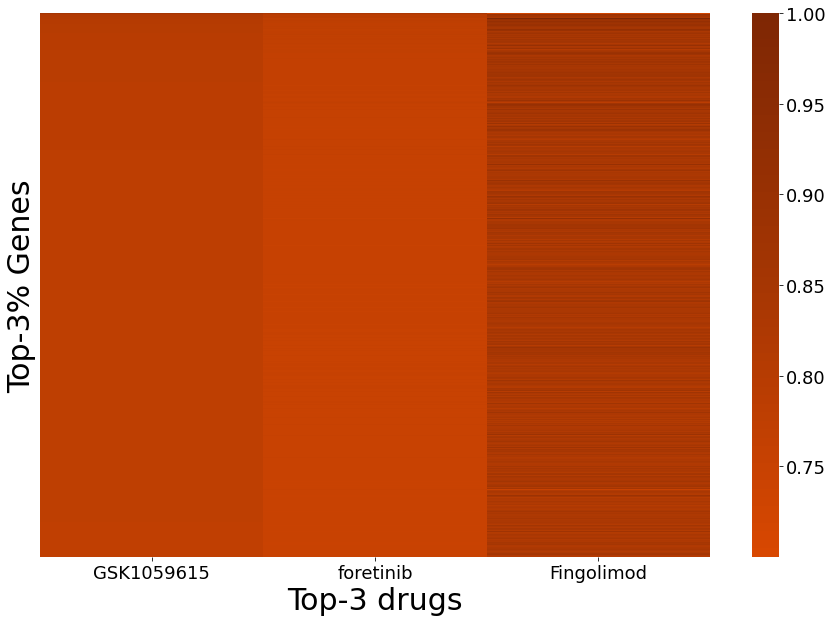

In [39]:
metric = 'loss'
cell_data = [cell_line_Me_feature_importance[metric], cell_line_Ex_feature_importance[metric], cell_line_CNV_feature_importance[metric], cell_line_Mu_feature_importance[metric]]
drug_related = pd.DataFrame([get_feature_importance_for_all(cell_data, top3[i]) for i in range(len(top3))], index = Y['test']['ori'].columns[top3], columns = list(X['train'][0].columns)+list(X['train'][1].columns)+list(X['train'][2].columns)+list(X['train'][3].columns))
drug_related.index = [drug_related.index[i].split(' ')[0] for i in range(len(drug_related.index))]
drug_related.columns = [drug_related.columns[i].split('_')[0] for i in range(len(drug_related.columns))]
plt.figure(figsize = (15, 10))
sns.heatmap(drug_related.T.sort_values(by = ['GSK1059615'], ascending=False)[:int(len(drug_related.columns) * 0.03)], cmap = 'Oranges', center = 0.4)
plt.yticks([])
plt.xlabel('Top-3 drugs', size = 30)
plt.ylabel('Top-3% Genes', size = 30)
file_dir = 'result/reaction/cell({})/'.format(Y['test']['ori'].index[cell_line])
# plt.savefig(file_dir + 'drug_importance_all.png', transparent = True)

In [ ]:
import pandas as pd
file_dir = 'result/reaction/cell({})/'.format(Y['test']['ori'].index[cell_line])
data = pd.read_csv(file_dir + 'result_panobinostat.csv')
data

In [ ]:
name = [94]
data.iloc[name, [1, 2, 5, 12]]

In [ ]:
name = [74, 84, 94, 104, 114, 124, 134, 144, 154, 164, 174, 184, 194, 204, 214, 224, 234]
data.iloc[name, [1, 2, 5, 12]]
size, a = [], []
for i in range(len(name)):
    try:
        if np.isnan(data.iloc[name[i], [12]].tolist()[0]):
            a.append([])
    except:
        get = data.iloc[name[i], [12]].tolist()[0].split(';')
        a.append(get)
        
    size.append(len(a[i]))
size

In [ ]:
import math

import matplotlib.pyplot as plt
color = ['royalblue' if i != len(name) - 2 else 'darkorange' for i in range(len(name)) ]
x = [-math.log(np.array(data.iloc[name, 5])[len(name) - 1 - i]) for i in range(len(name))]
y = [np.array(data.iloc[name, 1])[len(name) - 1 - i] for i in range(len(name))]
fig, ax = plt.subplots(figsize = (40, 20))
# plt.scatter([-math.log(np.array(data.iloc[name, 7])[9-i]) for i in range(10)], [i for i in range(10)], color = color, s = [size[9 - i] for i in range(len(size))])
plt.scatter(x, y, color = color, s = [size[len(name) - 1 - i] * 400 for i in range(len(size))])

plt.xlabel('-log(p-value)', fontsize=60, labelpad = 20)
plt.xticks(fontsize = 40)
plt.yticks(fontsize = 25)
plt.ylabel('pathway name', fontsize=60, labelpad = 20)
plt.tight_layout()
# plt.savefig(file_dir + 'GSK1059615_scatter.png', transparent = True)

In [106]:
x[8]

3.293467916676554

In [114]:
-math.log(0.028280068)

3.565598033430489